# Exploring Methods of Handling Imbalanced Data
---
Real world data is messy, it is rare to come across categorical data with perfectly even classes so we need to learn how to deal with this kind of data. Resampling is a widely used technique for dealing with imbalanced data. Resampling is a method of increasing the observations (oversample) in the minority classes by duplicating observations or randomly removing (undersample) observations in the majority classes to even out the classes. 
![](resample.png)

Resampling comes at a price. Oversampling minority classes can result in overfitting and randomly removing observations from majority classes can cause the dataset to lose important information.  

Using the well known Ames housing dataset we will explore various methods of resampling to understand the effect they have on a models ability to accurately predict a minority class 

## Notebook Contents
[Library & Data Imports](#imports)  
[Exploratory Data Analysis](#eda)  
[Train-Test Split](#tts)  
[Baseline Model](#rfc)  
[Downsample with Resample](#downsample)   
[Upsample with Resample](#upsample)  
[Upsample with SMOTE](#smote)  
[SMOTE Grid Search Optimization](#smote_gs)  
[Combination Resampling with SMOTEENN](#smeen)  
[Balanced Bagging Classifier](#bbc)  
[BBC Grid Search Optimization](#bbc_gs)  
[Comparison of Resampling Methods](#compare) 

<a id='imports'></a>
# Import Libraries & Load Data

In [65]:
#set a global random seed for reproducability
import random
random.seed(63261)

# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy

# Model & Traditional Model Eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

# Resampling Methods
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## import the dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('classification.csv')

<a id='eda'></a>
# Exploratory Data Analysis

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,138500


**We are going to clean our dataset in a rough manner to quickly prepare it for modeling. The function below will standardize the column names, convert categorical features with hierarchical entries (good, bad, fair) into numerical features, replace meaningful null values with "None" & drop the remaining features that contail null values. We will also create a boolean target features to show whether or not the sale condition of a home was abnormal. **

**The purpose of this notebook is to understand how different resampling techniques impact the overall model performance so we're not concerned with having the best features in our model**

In [4]:
def clean_cols(df):
    # Standardize column names
    df.columns = map(str.lower, df.columns)
    df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
    
    #convert the categorical (good, bad, excellent) data into numbers
    col_dict = {"Ex":5, "Gd":4, "TA":3,"Fa":2, "Po":1}
    categorical_cols = ['exter_qual','exter_cond','bsmt_cond','bsmt_qual','fireplace_qu',
                    'garage_qual','garage_cond','kitchen_qual','heating_qc', 'pool_qc']
    for col in categorical_cols:
        df[col] = df[col].map(col_dict)
    
    # replace meaningful null values with "None
    # "meaningful" is based on information in the data dictionary
    null_cols = ['alley','garage_type','garage_finish','fence','misc_feature']
    for col in null_cols:
        df[col] = df[col].replace(np.NaN,"None")
        
    # Drop all columns with null values, 
    # For the purposes of this project I don't want to spend time imputing null values    
    df.dropna(axis =1, inplace=True)
    df.drop(['id', 'pid'], axis=1, inplace=True)

    # Create a boolean column to show whether or not a sale was abnormal
    df['abnormal_sale'] = df['sale_condition'].map(lambda x: 1 if x =="Abnorml" else 0)
    
clean_cols(df)

**The dataset is clearly heavily imbalanced with the majority of home sales being _not abnormal_. We will try to improve the true positives score for the abnormal sale class**

The total percentage of abnormal home sales is: 6.43588493418


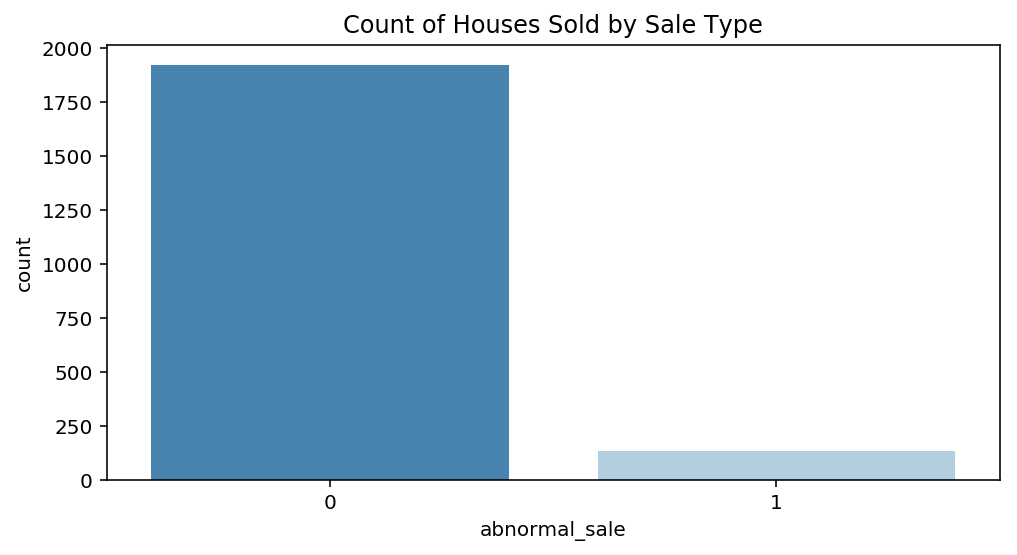

In [5]:
print("The total percentage of abnormal home sales is:", sum(df.abnormal_sale)/len(df.abnormal_sale)*100)

plt.subplots(figsize=(8,4))
plt.title("Count of Houses Sold by Sale Type")
sns.countplot(data = df, x='abnormal_sale', palette = 'Blues_r');

**Below is a function that will generate two plots. One plot shows the percentage of home sales that were abnormal by category compared to the overall percentage of home sales that were abnormal. The other plot shows the number of homes in each each category**

In [6]:
# Visualize the relationship between features & the target

def plot_categories (col, target = 'abnormal_sale', target_percent = 0.06435, data = df):
    fig = plt.figure(figsize=(20,4))
    fig.add_subplot(1,2,1)
    subset= df.groupby(col).agg({"abnormal_sale":"sum"})/ \
            df.groupby(col).agg({"abnormal_sale":"count"})
    subset = subset.reset_index().sort_values(target, ascending=False)
    plt.title("Percentage of Abnormal Home Sales")
    plt.axhline(y = target_percent, c='red')
    sns.barplot(x = col , y = target, data = subset, palette='Blues_r')
    plt.ylabel("Percentage of Abnormal Home Sales")
    plt.xlabel(col)

    fig.add_subplot(1,2,2)
    plt.title("Count of Homes")
    sns.countplot(x = col, data = data, palette='Blues_r')
    plt.xlabel(col);

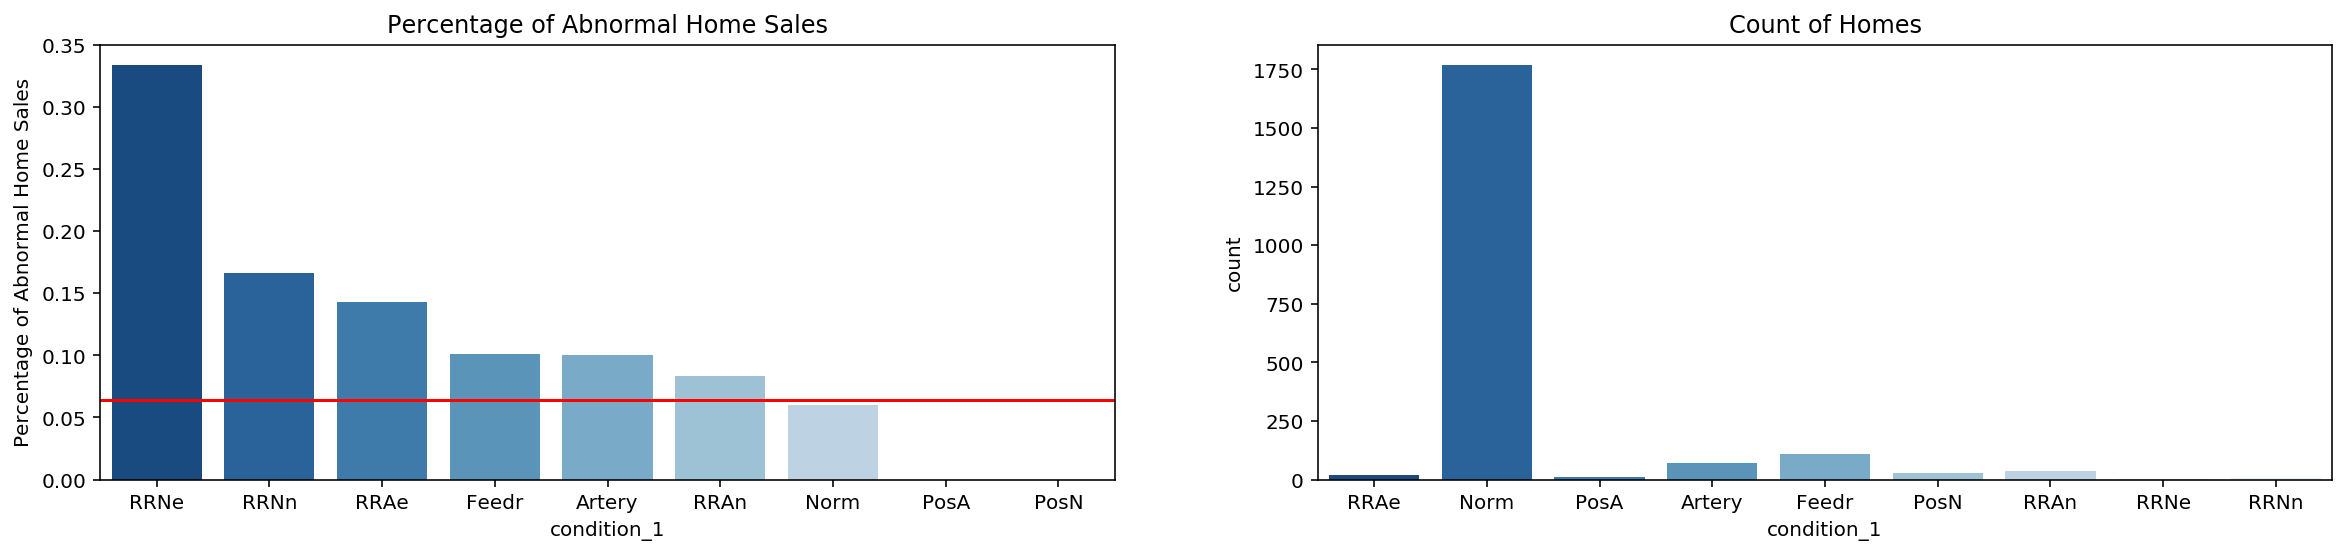

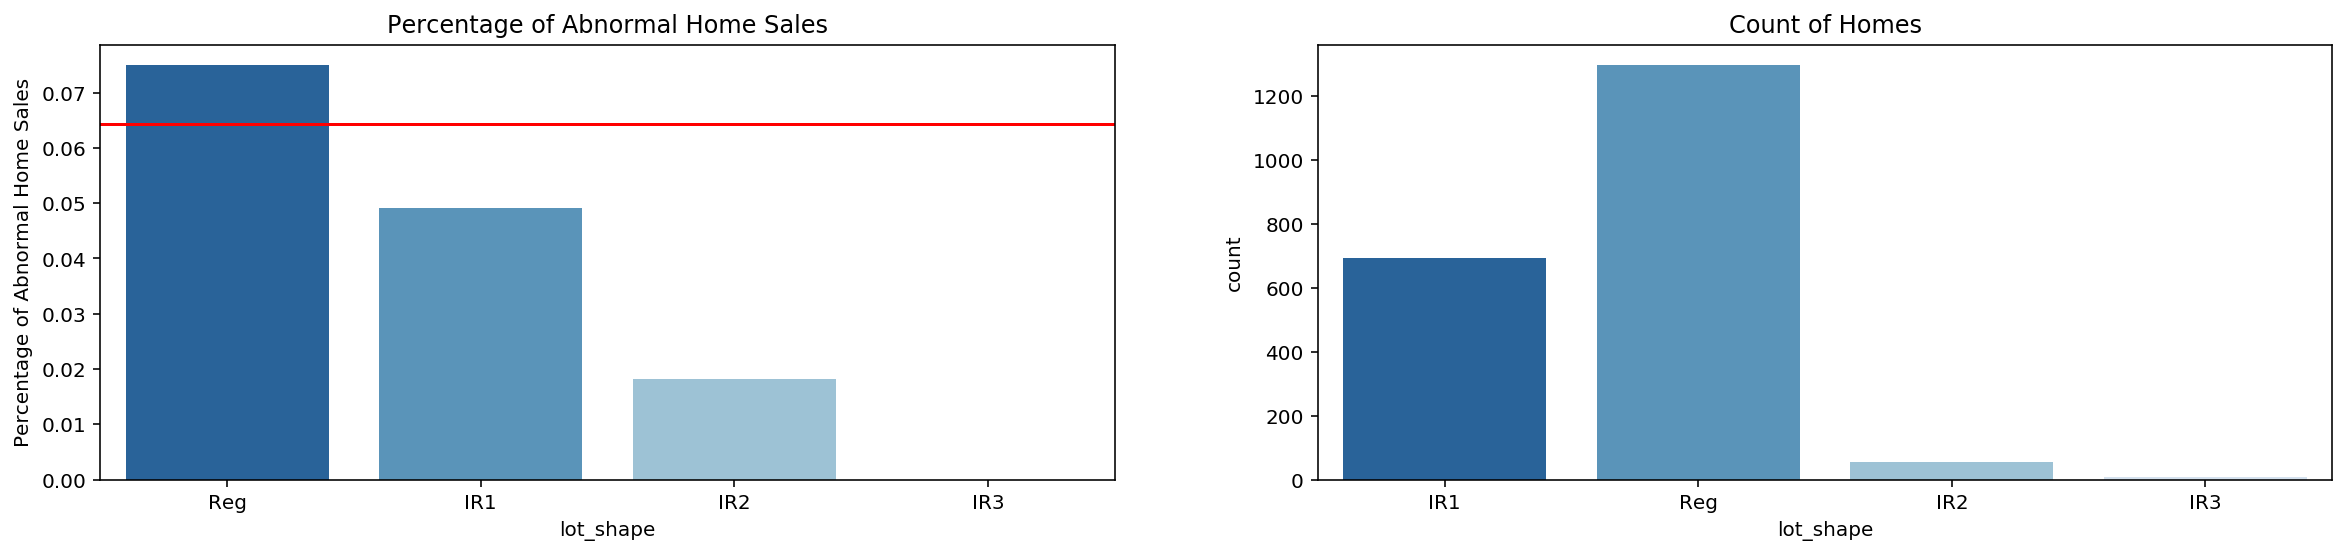

In [7]:
# example of visualizations that can be made to understand the relative importance of features
category_list = ['condition_1', 'lot_shape']
for col in category_list:
    plot_categories(col)

In [8]:
# Create dummy columns of "relevant" categorical columns
# Relevant columns were determined based on the relationships plotted above

def object_cols(df):
    col = df.select_dtypes(include = ['object']).copy()
    col.fillna("None", inplace=True)
    obj_col = patsy.dmatrix('~ sale_type + lot_shape + lot_config + neighborhood + exterior_1st +\
                            exterior_2nd + foundation + garage_type + garage_finish -1', 
                            data = col, return_type = 'dataframe')
    return obj_col

numeric_keep = ['overall_qual', 'year_built','year_remod/add', '1st_flr_sf', 'full_bath', 'gr_liv_area']
num_col = df[numeric_keep]
obj_cols = object_cols(df)

train = pd.concat([obj_cols, num_col], axis=1)

# Train-Test Split

In [9]:
baseline = df.abnormal_sale.value_counts()[0]/sum(df.abnormal_sale.value_counts())
baseline

0.93564115065821551

In [10]:
X = train.values
y = df.abnormal_sale.values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.5, 
                                                    random_state = 77,
                                                    stratify = y)

**For the train test split we stratify on y to ensure that the distribution of classes is the same in both the test set & the training set.**

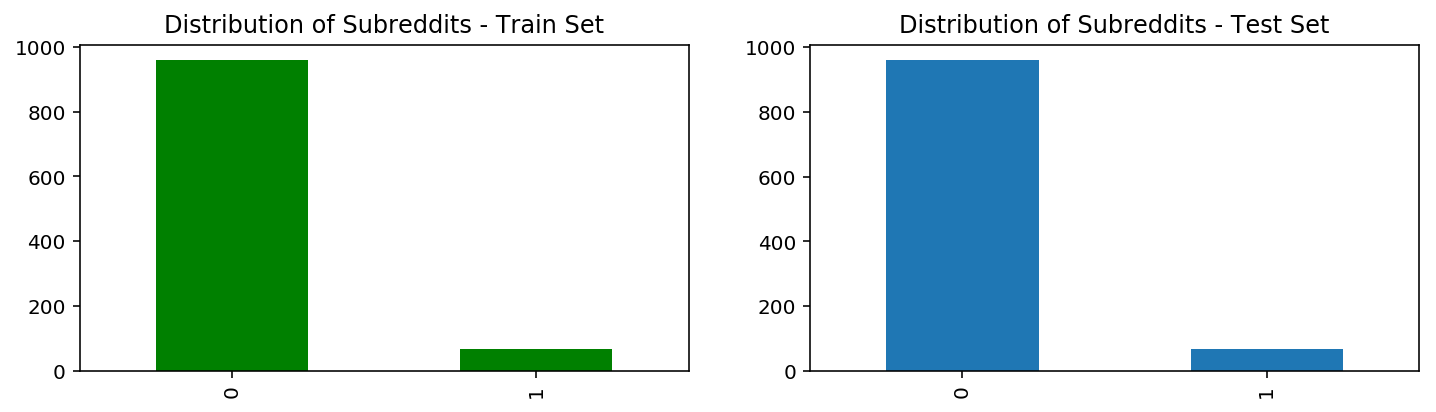

In [11]:
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
pd.value_counts(y_train).plot(kind="bar", color='green')
plt.title('Distribution of Subreddits - Train Set')

plt.subplot(1,2,2)
pd.value_counts(y_test).plot(kind="bar")
plt.title('Distribution of Subreddits - Test Set');

<a id='rfc'></a>
# Baseline Model

**The baseline for this model is based on the majority class as opposed to the target class. We can think about the baseline as the answer to the question: "if this model predicts the most common output, how often would it be correct?" **

**The model that we will use for this exploration of various resampling techniques is a random forest classifier. Random forest classifiers handle imbalanced data relatively well due to the randomness that they introduce in each decision tree**

**The scores that will be referenced in this notebook for each model and used to optimize models with grid search will be the recall score of the minority class and not the default accuracy score. **

In [12]:
rfc = RandomForestClassifier(random_state=620)

rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_score = recall_score(y_test, rfc_predict)

print ("Random Forest Test Score:", rfc_score)

Random Forest Test Score: 0.0606060606061


**We can see that the accuracy score of the unoptimized model for the test dataset is approximately the same as the baseline. On the surface this suggests that we're not doing any better than random guessing so we will take a look at the confusion matrix to understand what the model is truly doing**

## Model Evaluation

In [13]:
rfc_predict = rfc.predict(X_test)
rfc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, rfc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
rfc_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,953,7
is_abnormal,62,4


**As expected, our model is assuming at most observations are *not_abnormal*. So it is performing the same as our baseline. Below is a heatmap that shows the recall scores for the baseline model. For the purposes of this project, we will attempt to increase the recall for the *abnormal* class**

In [14]:
print(classification_report(y_test, rfc_predict))

             precision    recall  f1-score   support

          0       0.94      0.99      0.97       960
          1       0.36      0.06      0.10        66

avg / total       0.90      0.93      0.91      1026



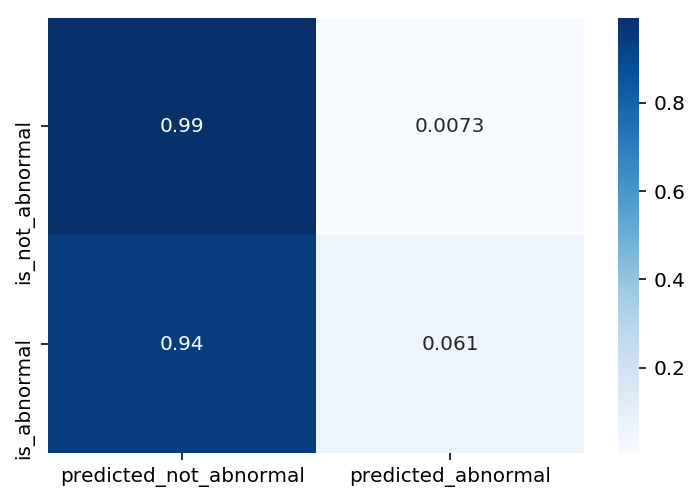

In [15]:
sns.heatmap(rfc_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

# Resample with sklearn.utils.resample

Resampling with sklearn is one of the most straightforward ways to balance a dataset. We can use this technique for both oversampling & undersampling. Before we can use sklearn resample, we have to separate the full dataset into two subsets, one containing the majority class and the other containing the minority class. Once we have our two subsets we can resample with or without replacement and then rejoin the subsets. 

We will fit our baseline model to the newly resampled training set and then score on the original test set to see how the recall scores differ

In [16]:
# recreate the full dataset used in our baseline model so that we can appropriate resample from it
data = pd.concat ([pd.DataFrame(X_train, columns=train.columns), 
                   pd.DataFrame(y_train, columns = ['abnormal_sale'])],
                  axis=1)

In [17]:
data.abnormal_sale.value_counts()

0    959
1     66
Name: abnormal_sale, dtype: int64

In [18]:
# Create subsets of dataframe for the majority & minority classes
# These will be used with sklearn resample
df_maj = data[data.abnormal_sale == 0]
df_min = data[data.abnormal_sale == 1]

<a id='downsample'></a>
## Downsample Majority Class 
---
**We will downsample the majority class to include only 250 samples. We randomly chose 250 as the number of samples that we will have in the majority class. Depending on the result of the model we can change increase or decrease the number of samples. **

In [111]:
df_downsample = resample(df_maj, replace=False, n_samples=150, random_state=240)
df_downsample = pd.concat([df_downsample, df_min])

In [112]:
X_down = df_downsample.drop('abnormal_sale', axis=1).values
y_down = df_downsample.abnormal_sale.values

In [113]:
rfc.fit(X_down,y_down)
ds_predict = rfc.predict(X_test)
ds_score = recall_score(y_test, ds_predict)

print ("Downsample Test Score:", ds_score)

Downsample Test Score: 0.333333333333


**Compared to our baseline model, the overall accuracy on the test set is worse. Does this mean that our downsampled model is worse?**

## Model Evaluation 

In [114]:
dsample_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, ds_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
dsample_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,845,115
is_abnormal,44,22


**Below is a heatmap that shows the recall scores for the model that was fit on the downsampled dataset. The recall score of our target has improved! Our new recall for the abnormal class is 0.33 and the recall in the baseline model was 0.06. Downsampling had a noticeable impact on our models ability to predict abnormal sales**

In [115]:
print(classification_report(y_test, ds_predict))

             precision    recall  f1-score   support

          0       0.95      0.88      0.91       960
          1       0.16      0.33      0.22        66

avg / total       0.90      0.85      0.87      1026



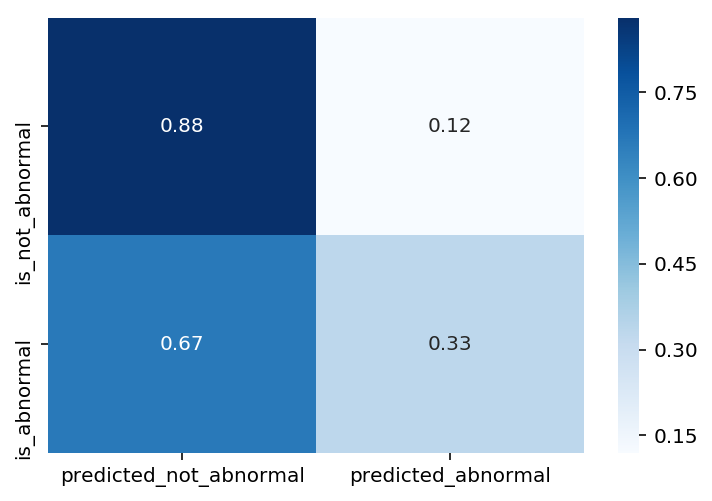

In [116]:
sns.heatmap(dsample_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

<a id='upsample'></a>
## Upsample Minority Class
---
**We will upsample the minority class by randomly repeating observations until we end up with 500 total samples. The number of samples was randomly chosen.** 

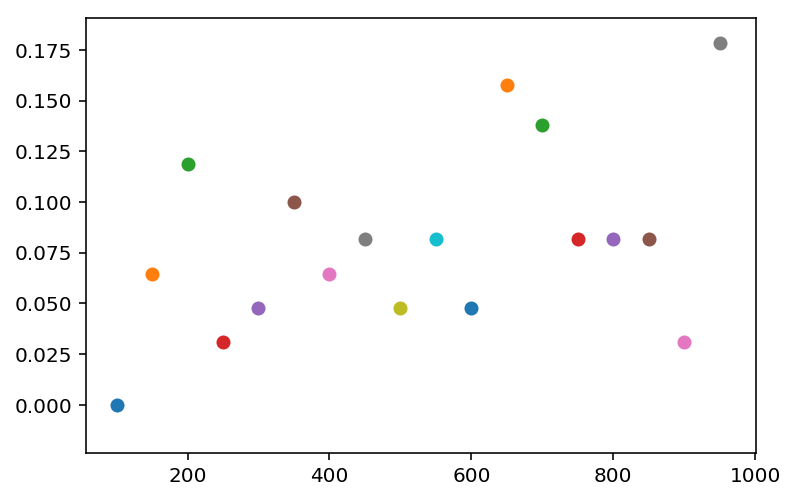

In [25]:
np.random.RandomState(240)
for k in np.arange(100, 1000, 50):
    df_upsample = resample(df_min, replace=True, n_samples=k, random_state=240)
    df_upsample = pd.concat([df_upsample, df_maj])
    X_up = df_upsample.drop('abnormal_sale', axis=1).values
    y_up = df_upsample.abnormal_sale.values
    rfc.fit(X_up,y_up)
    rfc_predict = rfc.predict(X_test)
    recall = confusion_matrix(y_test, rfc_predict).ravel()[3]/confusion_matrix(y_test, rfc_predict).ravel()[2]
#     print ('Accuracy for Minority Class for k=',k, ':', recall)
    plt.scatter(k, recall)

**Above is a function that explores the recall score for the minority group with a different number of samples (k) and then plots the resulting score against the chosen k. We can use this plot to determine the optimal number of samples to generate in order to maximize the predictions of our minority class.**

In [26]:
df_upsample = resample(df_min, replace=True, n_samples=650, random_state=240)
df_upsample = pd.concat([df_upsample, df_maj])

In [27]:
X_up = df_upsample.drop('abnormal_sale', axis=1).values
y_up = df_upsample.abnormal_sale.values

In [28]:
rfc.fit(X_up,y_up)
us_predict = rfc.predict(X_test)
us_score = recall_score(y_test, us_predict)

print ("Downsample Test Score:", us_score)

Downsample Test Score: 0.136363636364


**Compared to the baseline model, the score on the test set of our upsampled model is about the same. Similar to what we've done for the previous models, we're going to look at the confusion matrix to understand how the model is truly performing and what it's actually predicting.**

## Model Evaluation

In [29]:
usample_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, us_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
usample_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,948,12
is_abnormal,57,9


**Below is a heatmap that shows the recall scores for the model that was fit on the upsampled dataset. The recall score of our target has improved, albeit not by much. Our new recall for the abnormal class is 0.14 and the recall in the baseline model was 0.06. Even though there was an increase the change in the recall score from the baseline model and the upsampled model is smaller than that of the downsampled model (0.26). **

**We optimized the number of samples based on the plot above**

In [30]:
print(classification_report(y_test, us_predict))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       960
          1       0.43      0.14      0.21        66

avg / total       0.91      0.93      0.92      1026



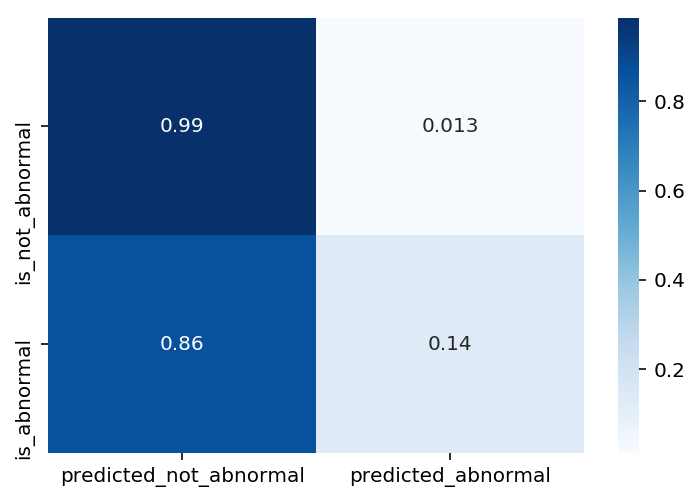

In [31]:
sns.heatmap(usample_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

<a id='smote'></a>
# SMOTE

Instead of oversampling with random replacement, we can oversample our minority classes with Synthetic Minority Oversampling TEchnique (SMOTE). While sklearn resample randomly replicates samples that exist in the dataset, SMOTE creates new samples based on interpolation. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors 
![](smote.png)

Considering a sample $x_i$, a new sample $x_{new}$ will be generated considering its k neareast-neighbors (corresponding to k_neighbors). For instance, the 3 nearest-neighbors are included in the blue circle as illustrated in the figure below. Then, one of these nearest-neighbors $x_{zi}$ is selected and a sample is generated as followswhere $\lambda$ is a random number in the range [0, 1]:

$$x_{new} = x_i + \lambda \times (x_{zi} - x_i)$$


SMOTE allows us to balance our data-set without as much overfitting, as we create new synthetic examples rather than using duplicates. This however does not prevent all overfitting, as these are still created from existing data points. SMOTE will create enough synthetic samples so that there are the same number of samples in each class

**We're going to create a function that explores the recall score for the minority group using different k's and then plots the resulting score against the chosen k. We will use this plot to determine the optimal k to maximize the predictions of our minority group.**

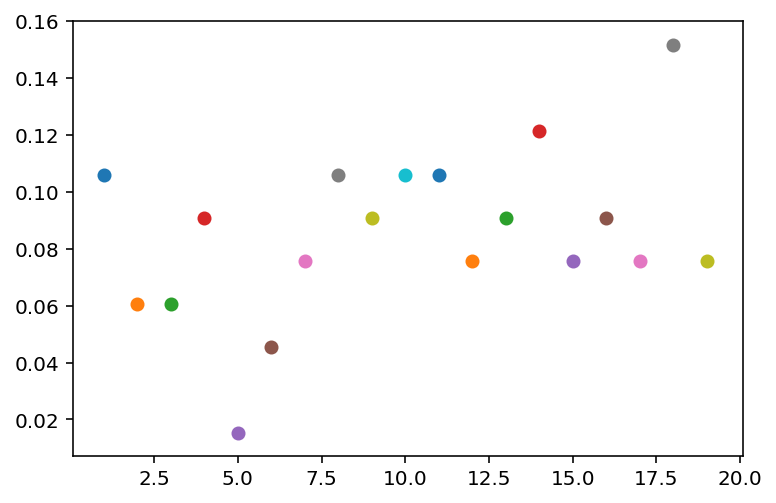

In [32]:
for k in range(1,20):
    sm = SMOTE(ratio = 'minority', k_neighbors=k, random_state=240)
    X_smote, y_smote = sm.fit_sample(X_train, y_train)
    rfc.fit(X_smote,y_smote)
    smote_predict = rfc.predict(X_test)
    recall = recall_score(y_test, smote_predict)
#     print ('Accuracy for Minority Class for k=',k, ':', recall)
    plt.scatter(k, recall)

**Based on the plot above, k=18 will give us the largest recall score for our target class. Unfortunately, it doesn't look like we will be able to achieve a score higher than 0.16**

In [33]:
sm = SMOTE(ratio='minority',k_neighbors=18, random_state=240)
X_smote, y_smote = sm.fit_sample(X_train, y_train)

In [34]:
rfc.fit(X_smote,y_smote)
smote_predict = rfc.predict(X_test)
smote_score = recall_score(y_test, smote_predict)

print ("Downsample Test Score:", smote_score)

Downsample Test Score: 0.151515151515


In [35]:
smote_predict = rfc.predict(X_test)
print(classification_report(y_test, smote_predict))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       960
          1       0.43      0.15      0.22        66

avg / total       0.91      0.93      0.92      1026



In [36]:
smote_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, smote_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
smote_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,947,13
is_abnormal,56,10


**SMOTE with optimal k (k=18) performs similarly to random upsampling. To me, this suggests that the features in the minority group are unique so that increasing the number of observations in the training set, either by randomly duplicating or generating similar samples, allowed our model to become better at predicting the features that contribute to the training set which are not effective at making predictions on the test set** 

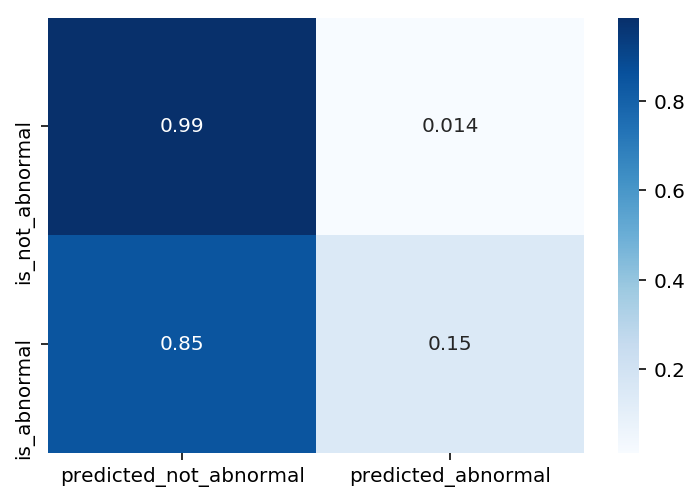

In [37]:
sns.heatmap(smote_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

<a id='smote_gs'></a>
# SMOTE Grid Search Optimization

In [38]:
sm_pipe = Pipeline([
    ('sm', SMOTE(ratio = 'minority', random_state=240)),
    ('rfc', rfc)
])

sm_params = {
    'sm__k_neighbors':np.arange(1,20),
    'sm__m_neighbors':np.arange(5, 20)
}

skf = StratifiedKFold(n_splits = 15, shuffle=True, random_state=514)

sm_gs = GridSearchCV(sm_pipe,
                     param_grid=sm_params,
                     scoring='recall',
                     cv = skf)

In [39]:
sm_gs.fit(X_train, y_train)
sm_gs_score = sm_gs.score(X_test,y_test)
print("Best Params: ", sm_gs.best_params_)
print("SMOTE Training Score: ", sm_gs.best_score_)
print ("SMOTE Test Score:", sm_gs_score)

Best Params:  {'sm__k_neighbors': 16, 'sm__m_neighbors': 5}
SMOTE Training Score:  0.120195121951
SMOTE Test Score: 0.0909090909091


In [40]:
sm_gs_predict = sm_gs.predict(X_test)
print(classification_report(y_test, sm_gs_predict))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       960
          1       0.29      0.09      0.14        66

avg / total       0.90      0.93      0.91      1026



In [41]:
sm_gs_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, sm_gs_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
sm_gs_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,945,15
is_abnormal,60,6


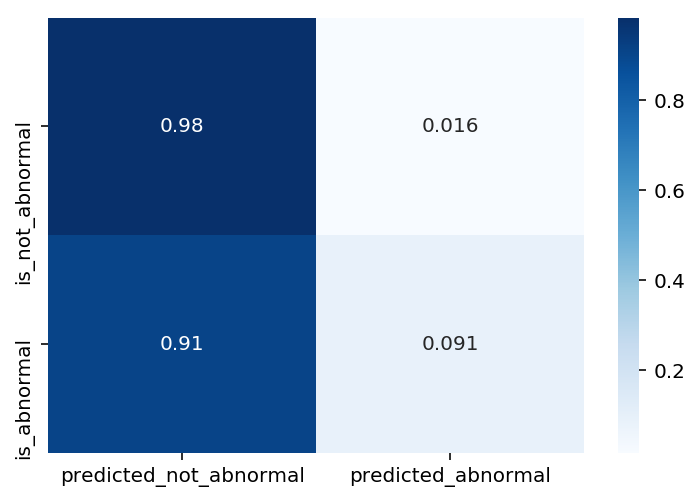

In [42]:
sns.heatmap(sm_gs_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

<a id='smeen'></a>
# SMOTEENN
---
SMOTEEN is a class that performs over-sampling using SMOTE and cleaning using Edited Nearest Neighbors (ENN). ENN is an undersampling technique that removes examples whose class label differs from the class of k nearest neighbors. To keep the sample in the dataset, its neighbors need to belong to the same class.

**NOTE**:  
In the newest version of the imbalanced learn package, both k (the number of neighbours to used to construct synthetic samples) and m (the number of neighbours to use to determine if a minority sample is in danger) have been deprecated. They are now included in the smote parameter. The default for this is the default SMOTE with no hyperparameters specified. The hyperparameter n_neighbors (the size of the neighborhood to consider to compute the average distance to the minority point samples) has also been deprecated and is included in the ENN parameter. 

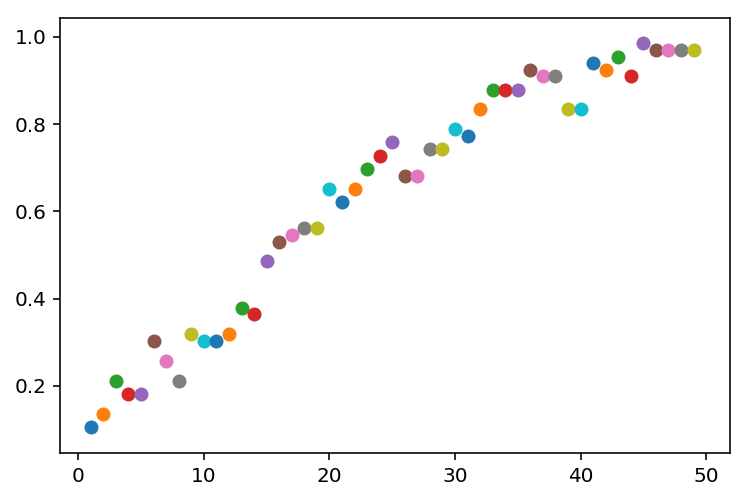

In [43]:
for k in range(1,50):
    enn = EditedNearestNeighbours(n_neighbors=k, ratio='majority')
    smeen = SMOTEENN(random_state = 6802524, enn=enn)
    X_smeen, y_smeen = smeen.fit_sample(X_train, y_train)
    rfc.fit(X_smeen,y_smeen)
    smeen_predict = rfc.predict(X_test)
    recall = recall_score(y_test, smeen_predict)
#     print ('Accuracy for Minority Class for k=',k, ':', recall)
    plt.scatter(k, recall)

**With a large enough n, SMOTEENN will allow us to predict our minority class 100% accurately. When this occurs, our model is perform exactly opposite of the baseline model; it will predict everything to be the minority class. Increasing the accuracy for the target class decreases the our accuracy on the majority group. Whether or not this is acceptable, depends on what's important**

In [44]:
# enn = EditedNearestNeighbours(n_neighbors=3)
smeen = SMOTEENN(smote= SMOTE(k_neighbors=5, ratio='minority'), 
                 enn=EditedNearestNeighbours(ratio='majority', n_neighbors=25),
                 random_state=6271)
X_smeen, y_smeen = smeen.fit_sample(X_train, y_train)

In [45]:
rfc.fit(X_smeen,y_smeen)
smeen_predict = rfc.predict(X_test)
smeen_score = recall_score(y_test, smeen_predict)

print ("SMOTEENN Test Score:", smeen_score)

SMOTEENN Test Score: 0.712121212121


In [46]:
smeen_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, smeen_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
smeen_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,447,513
is_abnormal,19,47


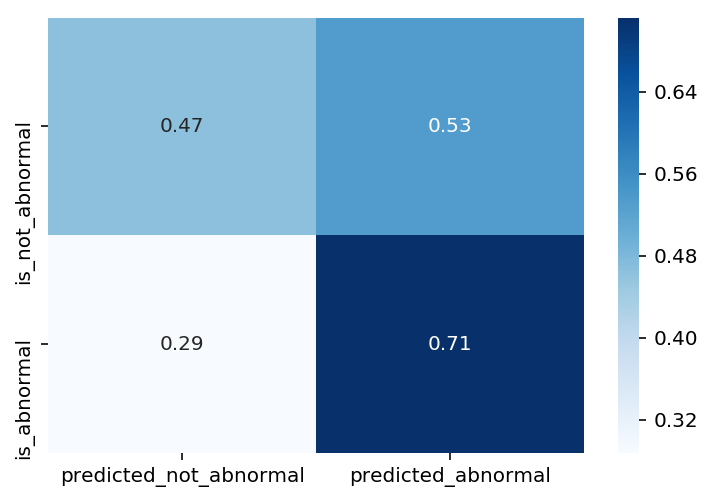

In [47]:
 sns.heatmap(smeen_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

# SMOTETomek
---

Similar to SMOTEENN, SMOTETomek is also a class that uses a combination of over and under-sampling. SMOTETomek is an undersampling techniques that uses Tomek links to determine which observations to remove. A Tomek link exists if the two samples are nearer to each other than to samples from their own class.  

A Tomek’s link between two samples of different class x and y is defined such that there is no example z such that:

$$d(x, y) < d(x, z) \text{ or } d(y, z) < d(x, y)$$

where d is the distance between the two samples

In [105]:
smomek = SMOTETomek(random_state = 61451,
                    smote = SMOTE(k_neighbors = 35, random_state=625),
                    tomek = TomekLinks(ratio='majority', random_state=936))

X_smomek, y_smomek = smomek.fit_sample(X_train, y_train)

In [106]:
rfc.fit(X_smomek,y_smomek)
smomek_predict = rfc.predict(X_test)
smomek_score = recall_score(y_test, smomek_predict)

print ("SMOTETomek Test Score:", smomek_score)

SMOTETomek Test Score: 0.166666666667


In [107]:
smomek_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, smomek_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
smomek_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,939,21
is_abnormal,55,11


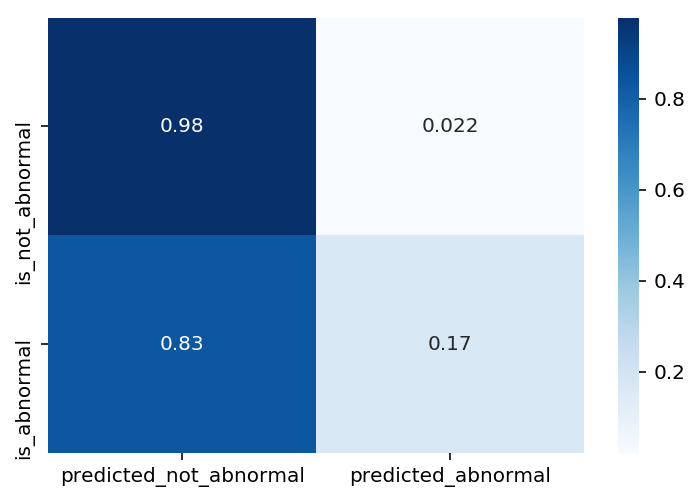

In [108]:
sns.heatmap(smomek_confusion.apply(lambda x: x/x.sum(),axis=1), 
            annot=True, cmap = 'Blues');

<a id='bbc'></a>
# Balanced Bagging Classifier
---
BalancedBaggingClassifier is the scikit-learn bagging classifier with an additional step of balancing the training set during the fit by randomly undersampling. It has the same parameters as BaggingClassifier with but also includes the parameters ratio & replacement that come from EasyEnsemble. In short, it combines the output of an EasyEnsemble sampler with an ensemble of classifiers that would otherwise favor the majority class.

In [48]:
bbc = BalancedBaggingClassifier(base_estimator = rfc,
                                random_state = 0)

In [49]:
bbc.fit(X_train,y_train)

bbc_predict = bbc.predict(X_test)
bbc_score = recall_score(y_test, bbc_predict)

print ("BBC Test Score:", bbc_score)

BBC Test Score: 0.484848484848


In [50]:
bbc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,747,213
is_abnormal,34,32


In [51]:
print(classification_report(y_test, bbc_predict))

             precision    recall  f1-score   support

          0       0.96      0.78      0.86       960
          1       0.13      0.48      0.21        66

avg / total       0.90      0.76      0.82      1026



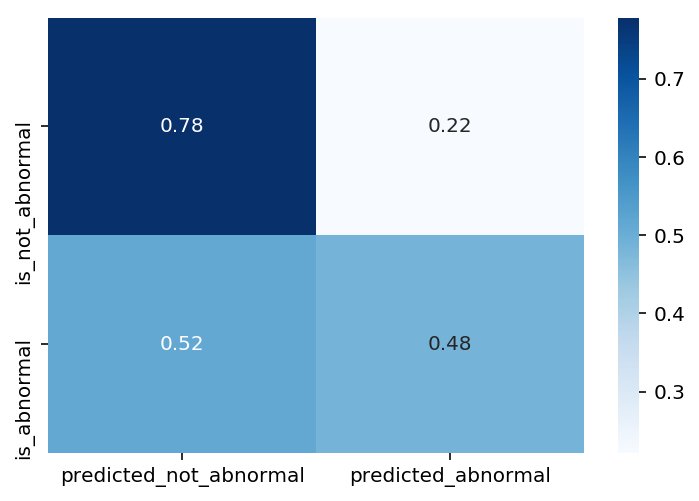

In [52]:
sns.heatmap(bbc_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

<a id='bbc_gs'></a>
# Balanced Bagging Classifer Grid Search Optimization

In [53]:
bbc_params = {
    'n_estimators':np.arange(5,20),
    'warm_start': [True, False]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)
}

bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='recall',
                     cv = 10)

In [54]:
bbc_gs.fit(X_train,y_train)
bbc_gs_score = bbc_gs.score(X_test, y_test)

print("Best Params: ", bbc_gs.best_params_)
print ("BBC Test Score:", bbc_gs_score)

Best Params:  {'n_estimators': 18, 'warm_start': True}
BBC Test Score: 0.515151515152


In [55]:
bbc_gs_predict = bbc_gs.predict(X_test)
bbc_gs_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_gs.predict(X_test))),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_gs_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,736,224
is_abnormal,32,34


In [56]:
print(classification_report(y_test, bbc_gs_predict))

             precision    recall  f1-score   support

          0       0.96      0.77      0.85       960
          1       0.13      0.52      0.21        66

avg / total       0.91      0.75      0.81      1026



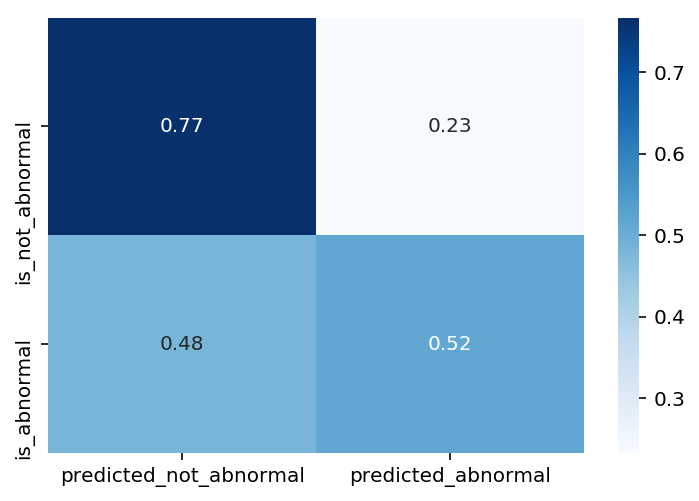

In [57]:
sns.heatmap(bbc_gs_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

<a id='compare'></a>
# Model Comparison

In [109]:
print ("Random Forest Score:", rfc_score, '\n'
      "Downsampled Score:", ds_score,'\n'
      "Upsampled Score", us_score,'\n'
      "Smote Score:", smote_score, '\n'
       "Smote Grid Search Score", sm_gs_score ,'\n'
       "SMOTEENN Score:", smeen_score, '\n'
       "SMOTETomek Score:", smomek_score, '\n'
      "BBC Score", bbc_score, '\n'
      "BBC Grid Search Score", bbc_gs_score)

Random Forest Score: 0.0606060606061 
Downsampled Score: 0.257575757576 
Upsampled Score 0.136363636364 
Smote Score: 0.151515151515 
Smote Grid Search Score 0.0909090909091 
SMOTEENN Score: 0.712121212121 
SMOTETomek Score: 0.166666666667 
BBC Score 0.484848484848 
BBC Grid Search Score 0.515151515152


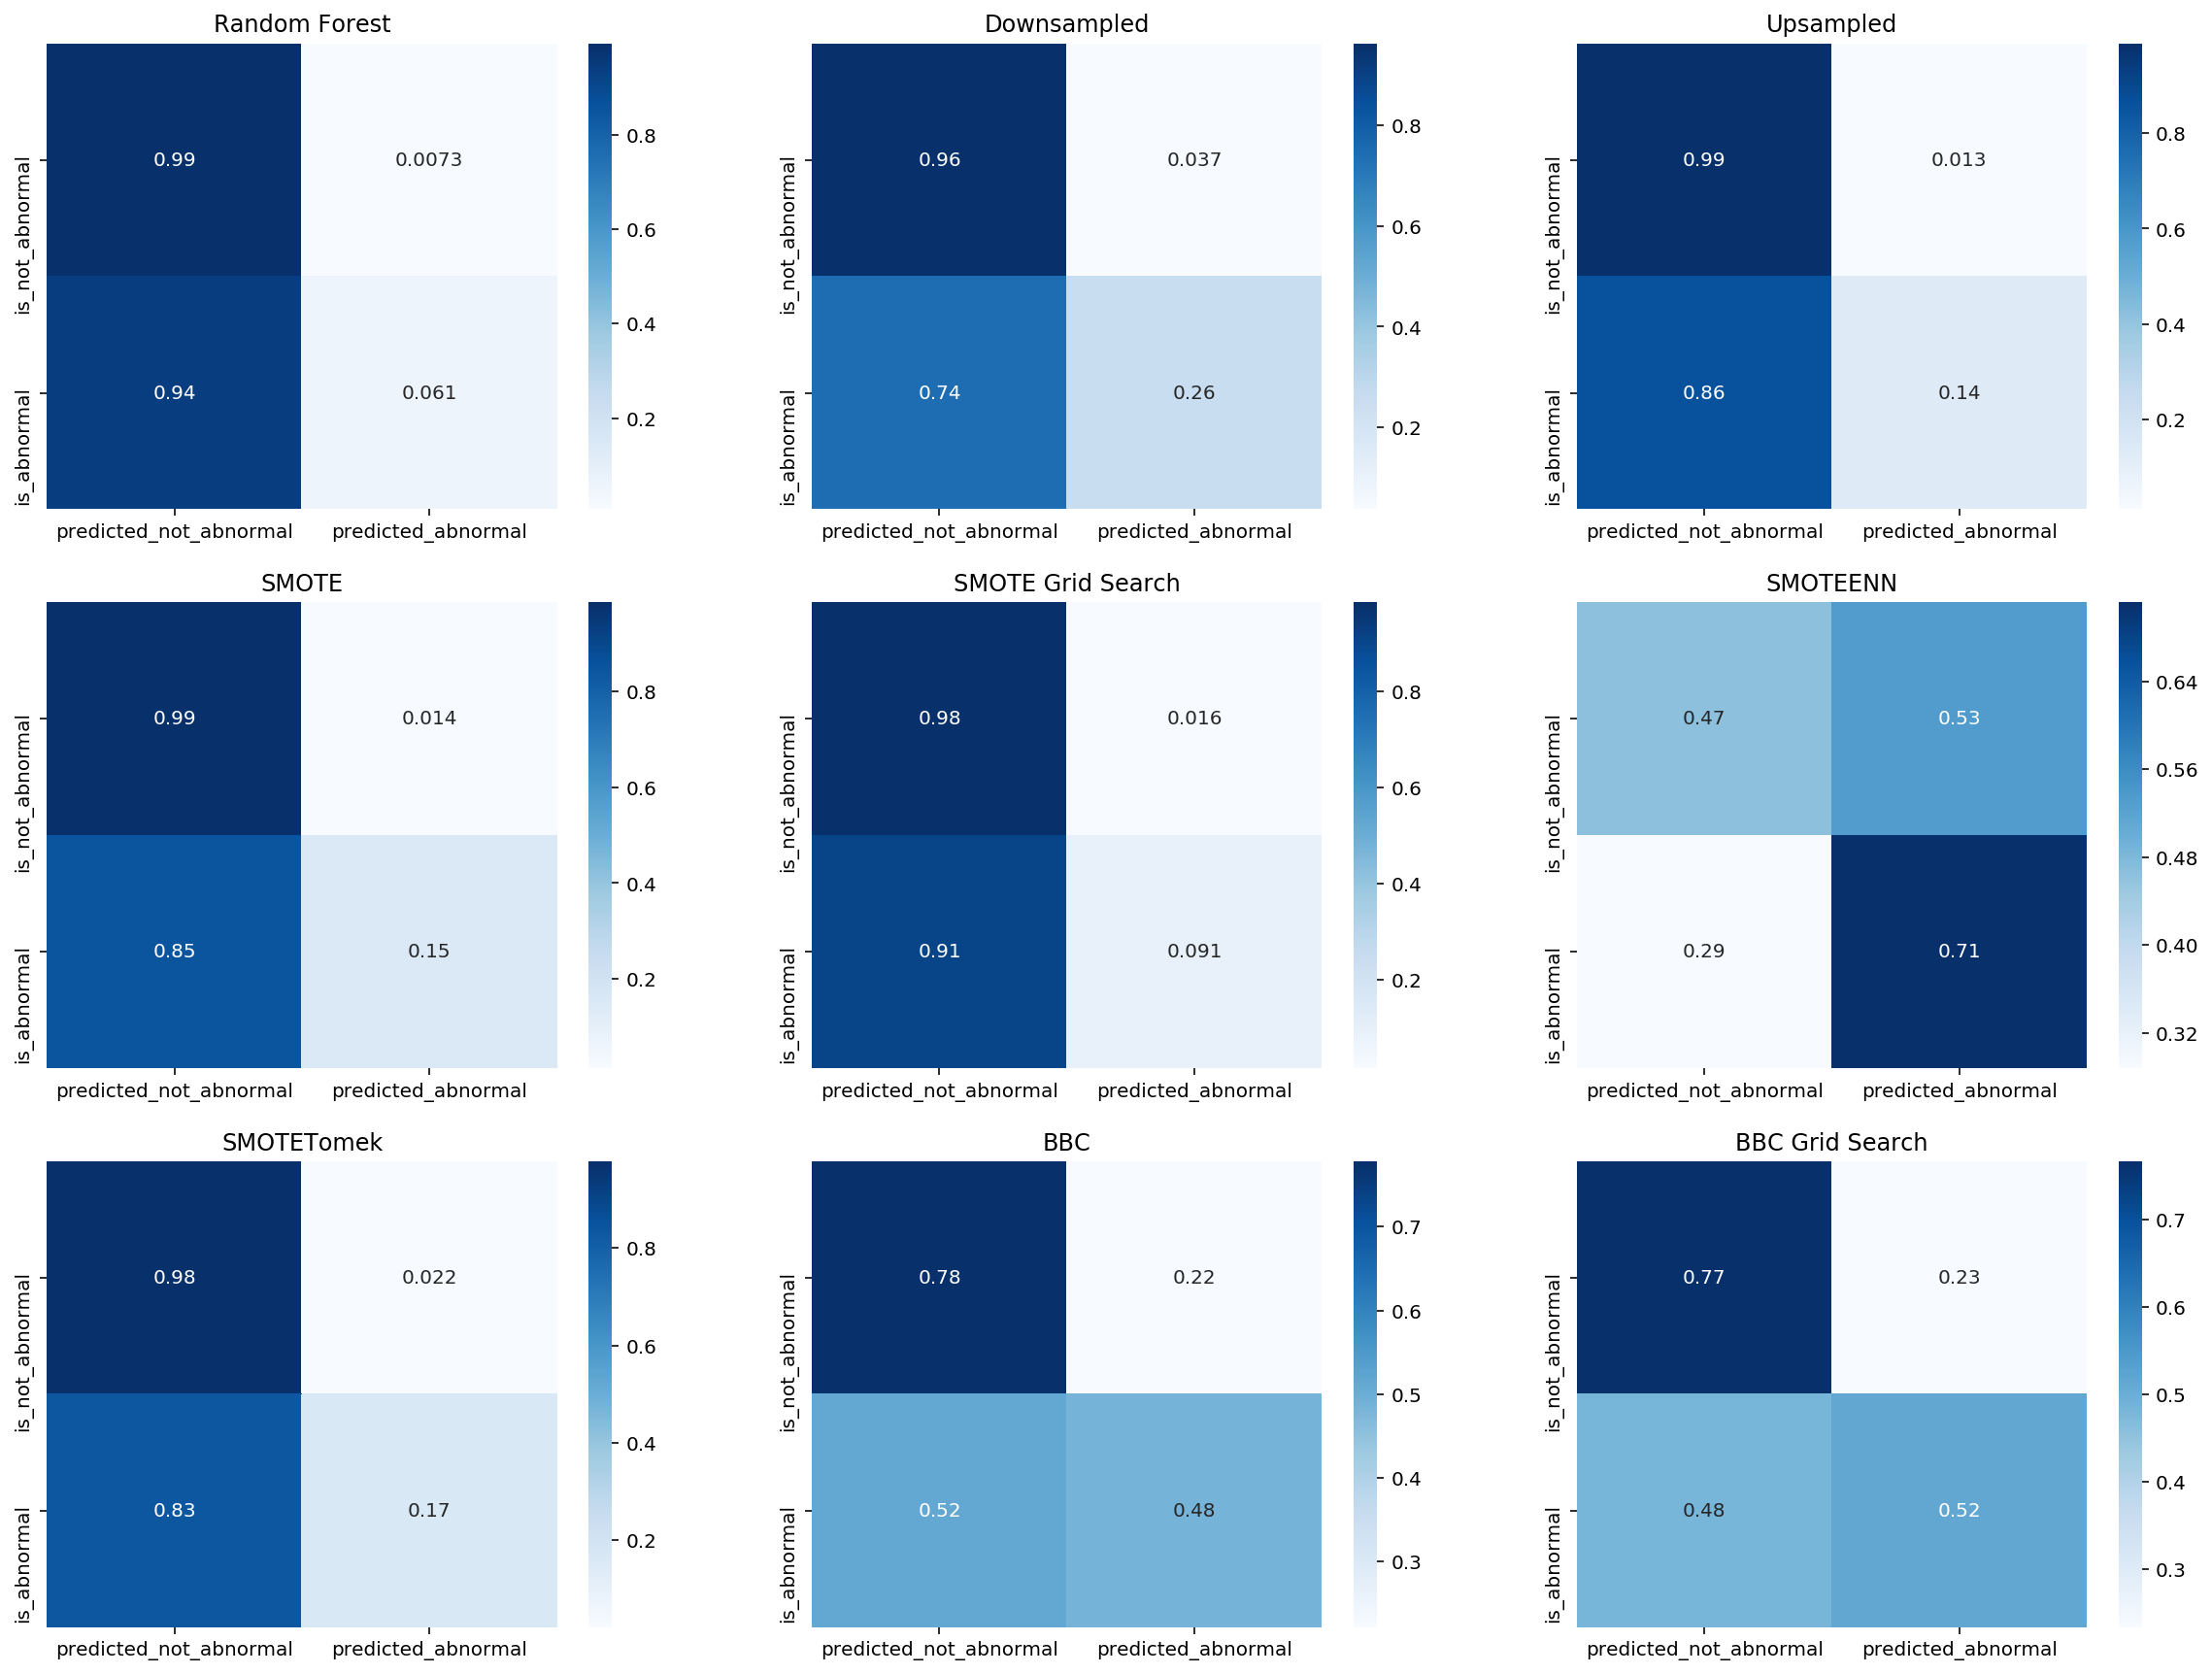

In [110]:
plt.figure(figsize=(20,15))

plt.subplot(3,3,1)
plt.title('Random Forest')
sns.heatmap(rfc_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,2)
plt.title('Downsampled')
sns.heatmap(dsample_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,3)
plt.title('Upsampled')
sns.heatmap(usample_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,4)
plt.title('SMOTE')
sns.heatmap(smote_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,5)
plt.title('SMOTE Grid Search')
sns.heatmap(sm_gs_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,6)
plt.title('SMOTEENN')
sns.heatmap(smeen_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,7)
plt.title('SMOTETomek')
sns.heatmap(smomek_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,8)
plt.title('BBC')
sns.heatmap(bbc_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')

plt.subplot(3,3,9)
plt.title('BBC Grid Search')
sns.heatmap(bbc_gs_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');